   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

                   Configuration      RMSE       MAE
0                  Full pipeline  1.516771  0.702127
1        Without outlier removal  1.279081  0.614499
2         Without moving average  0.689855  0.239223
3          Without normalization  1.499931  0.953862
4  Without Bayesian Optimization  1.642229  0.939146


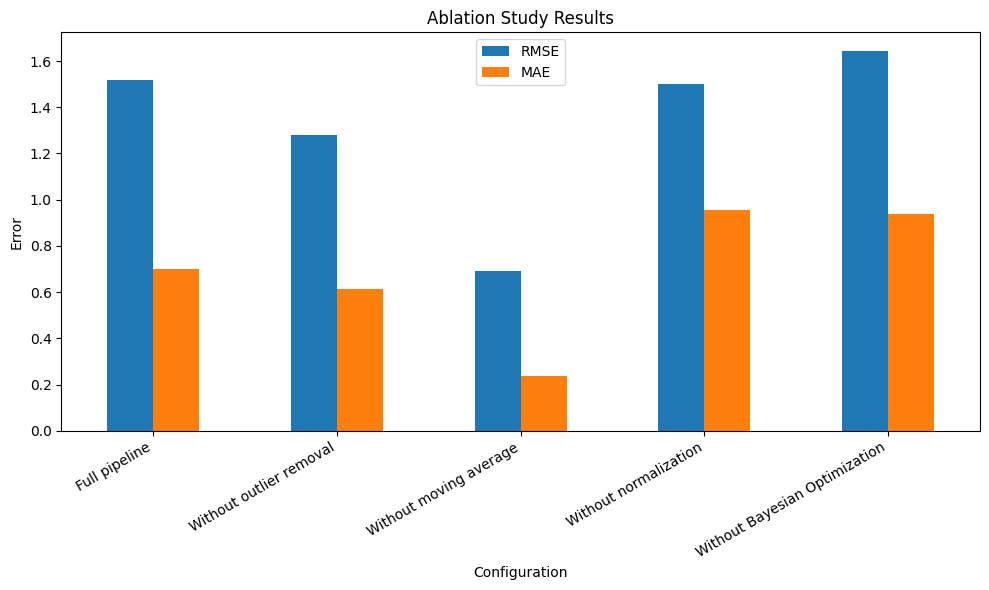

In [ ]:
# Install keras-tuner before importing it
!pip install -q keras-tuner
import scipy.io
import keras_tuner as kt  # <- corrected import
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt

# --------------------------------------------------------
# 1. Load Data
# --------------------------------------------------------
train_data = pd.read_excel("Train.xlsx")
test_data = pd.read_excel("Test.xlsx")

# Assume target column is last column
X_train_raw, y_train_raw = train_data.iloc[:, :-1], train_data.iloc[:, -1]
X_test_raw, y_test_raw = test_data.iloc[:, :-1], test_data.iloc[:, -1]

# --------------------------------------------------------
# 2. Preprocessing functions
# --------------------------------------------------------
def remove_outliers(df):
    z_scores = np.abs(zscore(df))
    return df[(z_scores < 3).all(axis=1)]

def moving_average(df, window=3):
    return df.rolling(window=window, min_periods=1).mean()

def normalize(train, test):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    return train_scaled, test_scaled, scaler

# --------------------------------------------------------
# 3. Model definition
# --------------------------------------------------------
def build_lstm_model(hp=None, input_shape=None, use_bo=True):
    model = Sequential()
    units = hp.Int("units", 32, 128, step=32) if (hp and use_bo) else 64
    model.add(LSTM(units, input_shape=input_shape))
    model.add(Dense(1))
    lr = hp.Float("lr", 1e-4, 1e-2, sampling="log") if (hp and use_bo) else 1e-3
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse", metrics=["mae"])
    return model

# --------------------------------------------------------
# 4. Training function
# --------------------------------------------------------
def train_lstm(X_train, y_train, X_test, y_test, use_bo=True):
    input_shape = (X_train.shape[1], 1)

    # Reshape for LSTM
    X_train = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))

    if use_bo:
        tuner = kt.RandomSearch(
            lambda hp: build_lstm_model(hp, input_shape, use_bo=True),
            objective="val_loss",
            max_trials=5,
            overwrite=True,
            directory="bo_tuning",
            project_name="lstm_ablation"
        )
        tuner.search(X_train, y_train, validation_split=0.2, epochs=20, verbose=0)
        best_model = tuner.get_best_models(1)[0]
    else:
        best_model = build_lstm_model(input_shape=input_shape, use_bo=False)
        best_model.fit(X_train, y_train, epochs=20, batch_size=32,
                       validation_split=0.2, verbose=0)

    loss, mae = best_model.evaluate(X_test, y_test, verbose=0)
    return np.sqrt(loss), mae   # RMSE, MAE

# --------------------------------------------------------
# 5. Ablation study
# --------------------------------------------------------
def run_ablation(X_train_raw, y_train_raw, X_test_raw, y_test_raw):
    results = []

    # --- Full pipeline ---
    X_train, X_test = remove_outliers(X_train_raw), X_test_raw
    y_train = y_train_raw.loc[X_train.index]  # match index after outlier removal
    X_train, X_test = moving_average(X_train), moving_average(X_test)
    X_train, X_test, _ = normalize(X_train, X_test)
    rmse, mae = train_lstm(X_train, y_train, X_test, y_test_raw, use_bo=True)
    results.append(["Full pipeline", rmse, mae])

    # --- Without outlier removal ---
    X_train, X_test = X_train_raw, X_test_raw
    y_train = y_train_raw
    X_train, X_test = moving_average(X_train), moving_average(X_test)
    X_train, X_test, _ = normalize(X_train, X_test)
    rmse, mae = train_lstm(X_train, y_train, X_test, y_test_raw, use_bo=True)
    results.append(["Without outlier removal", rmse, mae])

    # --- Without moving average ---
    X_train, X_test = remove_outliers(X_train_raw), X_test_raw
    y_train = y_train_raw.loc[X_train.index]
    X_train, X_test, _ = normalize(X_train, X_test)
    rmse, mae = train_lstm(X_train, y_train, X_test, y_test_raw, use_bo=True)
    results.append(["Without moving average", rmse, mae])

    # --- Without normalization ---
    X_train, X_test = remove_outliers(X_train_raw), X_test_raw
    y_train = y_train_raw.loc[X_train.index]
    X_train, X_test = moving_average(X_train), moving_average(X_test)
    rmse, mae = train_lstm(X_train, y_train, X_test, y_test_raw, use_bo=True)
    results.append(["Without normalization", rmse, mae])

    # --- Without Bayesian Optimization ---
    X_train, X_test = remove_outliers(X_train_raw), X_test_raw
    y_train = y_train_raw.loc[X_train.index]
    X_train, X_test = moving_average(X_train), moving_average(X_test)
    X_train, X_test, _ = normalize(X_train, X_test)
    rmse, mae = train_lstm(X_train, y_train, X_test, y_test_raw, use_bo=False)
    results.append(["Without Bayesian Optimization", rmse, mae])

    return pd.DataFrame(results, columns=["Configuration", "RMSE", "MAE"])

# --------------------------------------------------------
# Run ablation
# --------------------------------------------------------
results = run_ablation(X_train_raw, y_train_raw, X_test_raw, y_test_raw)
print(results)

# --------------------------------------------------------
# Plot results
# --------------------------------------------------------
results.plot(x="Configuration", y=["RMSE","MAE"], kind="bar", figsize=(10,6))
plt.ylabel("Error")
plt.title("Ablation Study Results")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()